In [23]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, recall_score
import pickle

In [3]:
df = pd.read_csv('../Data/02_sub_reddit_data_clean.csv')

In [4]:
df.head(2)

,id,subreddit,title,utc_datetime_str,num_comments,day_name,title_word_count,negative_score,neutral_score,positive_score,compound_score
0,12xzq7k,AskMen,"Men who had an affair, left their wife, and no...",2023-04-24 22:57:05,1,Monday,12,0.203,0.797,0.0,-0.4215
1,12xzptl,AskMen,"Men, what would your thoughts be after learnin...",2023-04-24 22:56:41,0,Monday,12,0.000,1.000,0.0,0.0000


In [5]:
X=df['title']
y=df['subreddit']

In [7]:
baseline = y.value_counts(normalize=True)
baseline

AskWomen    0.505497
AskMen      0.494503
Name: subreddit, dtype: float64

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, test_size=.25, stratify=y)

# Random forest

In [9]:
pipe = Pipeline([
    ('cvec', CountVectorizer())
    ,('rt', RandomForestClassifier())
])

In [10]:
cross_val_score(pipe, X_train, y_train, cv=3).mean()

0.6875

In [11]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('cvec', CountVectorizer()), ('rt', RandomForestClassifier())])

In [14]:
print(f' Training score is {pipe.score(X_train, y_train)}')
print(f' Test score is {pipe.score(X_test, y_test)}')

 Training score is 0.9945987654320988
 Test score is 0.6977640709329221


In [55]:
pipe_params = {
    'cvec__lowercase': [True],
    'cvec__max_features': [30, 50, 75.],
    'cvec__min_df': [2, 3, 9],
    'cvec__max_df': [0.80, 0.90],
    'cvec__ngram_range': [(1, 1), (2,2), (3,3)],
    'cvec__stop_words' : ['english', None],
    'rt__min_samples_leaf': [3, 5, 6],
    'rt__max_depth': [10, 15, 20],
    'rt__bootstrap': [True]
    
}

In [56]:
gs = GridSearchCV(pipe,
                 param_grid=pipe_params,
                 cv=5, n_jobs = -1)

In [ ]:
gs.fit(X_train, y_train)

In [65]:
display(gs.best_params_)

{'cvec__lowercase': True,
 'cvec__max_df': 0.9,
 'cvec__max_features': 30,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': None,
 'rt__bootstrap': True,
 'rt__max_depth': 15,
 'rt__min_samples_leaf': 6}

Best parmas for a countvector and random forest

|Param|setting|
|-----|-----|
|cvec__max_df| .9|
|cvec__max_features| 30|
|cvec__min_df| 2|
|cvec__ngram_range| (1, 1)|
|cvec__stop_words| None|
|rt__bootstrap| True|
|rt__max_depth| 15|
|rt__min_samples_leaf| 6|

In [66]:
gs.score(X_train, y_train)

0.7379115226337448

In [67]:
gs.score(X_test, y_test)

0.6638396299151889

In [70]:
preds = gs.predict(X_test)

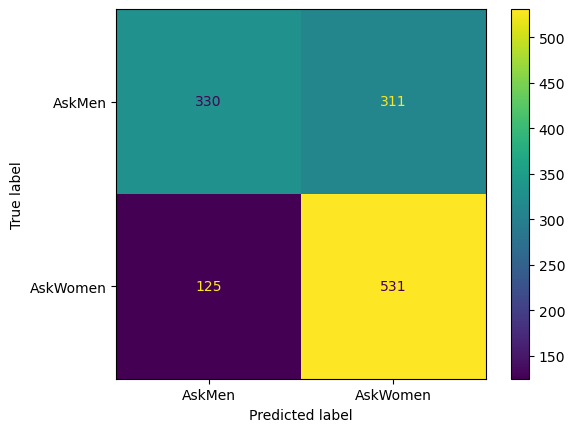

In [71]:
ConfusionMatrixDisplay.from_estimator(gs, X_test, y_test)

In [74]:
recall_score(y_test, preds, average='macro')

0.662135906167954

In [68]:
rf_model_1 = gs

In [69]:
with open('../Models/model_pickel1.pkl', 'wb') as pickle_out:
    pickle_out = pickle.dump(rf_model_1, pickle_out)

This model does better than baseline, but is slightly overfit. It also misclassifies 36% of the predictions for Askwomen and 27% of the predictions for Askmen. With a recall score of 66% this model is not sufficient for production.